In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**According to Plato, "Music gives a soul to the universe, wings to the mind, flight to the imagination & life to everything."**

**According to Maria Von Trapp, "Music acts like a magic key to which the most tightly closed heart opens."**

**In this notebook, let us classify the music samples into different genres & predict the genre using an audio signal as an input. The objective of automating the music classification is to make the selection of songs quick and less cumbersome.**

**IMPORTING LIBRARIES**

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

# !pip install xgboost -U
# !pip install librosa -U
# !pip install hyperopt

import os
from tqdm import tqdm
import pickle
import scipy
import sys
import pandas as pd
import numpy as np
import IPython
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import librosa #Python package for music & audio files
import librosa.display
import librosa.display as lplt

from tensorflow import keras
from keras.models import Sequential
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


**LOADING & PREPROCESSING THE DATA**

In [ ]:
# read csv from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/cs534_music_classification/Data/features_3_sec.csv'
df = pd.read_csv(path)
df
final_data=df

In [ ]:
#Reading the csv file
# final_data = pd.read_csv("Data/features_3_sec.csv")

In [ ]:
import librosa

In [ ]:
final_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [ ]:
final_data.shape

(9990, 60)

In [ ]:
final_data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [ ]:
final_data = final_data.drop(labels='filename',axis=1)

In [ ]:
#audio file
audio = "/content/drive/MyDrive/cs534_music_classification/Data/genres_original/classical/classical.00035.wav"
#Load & decode the audio as a time series, where sr represents the sampling rate
data , sr = librosa.load(audio)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
librosa.load(audio, sr=45600)

(array([0.00919421, 0.01321545, 0.01448904, ..., 0.01861604, 0.01628   ,
        0.00850596], dtype=float32), 45600)

In [ ]:
#Playing the audio within the notebook
IPython.display.Audio(data, rate=sr)

### AUDIO VISUALIZATION

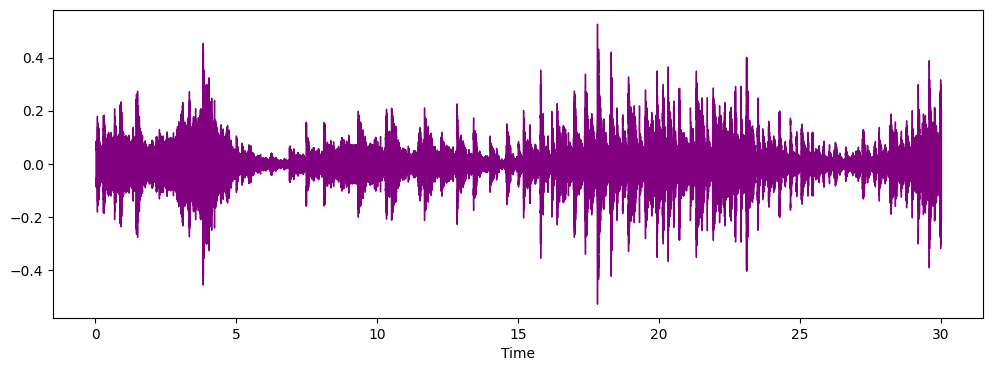

In [ ]:
#Plotting the raw wave file to quickly scan the audio data & contrast which genres might be more similar.

plt.figure(figsize=(12,4))
librosa.display.waveshow(data, color = "Purple")
plt.show()

[[ 5.3115779e-01+0.0000000e+00j  2.4507321e-01+0.0000000e+00j
   5.4738313e-01+0.0000000e+00j ...  2.0316027e-01+0.0000000e+00j
  -6.6318905e-01+0.0000000e+00j -1.5469117e+00+0.0000000e+00j]
 [-5.7227200e-01+1.0892269e-01j  1.0663314e-01-4.1306999e-01j
  -1.3865082e-01+6.9585729e-01j ...  9.7307190e-03-7.4860716e-01j
   3.7655336e-01-4.2681962e-02j  8.0510724e-01-8.3020353e-01j]
 [ 3.9483312e-01-2.9465267e-01j -3.4565154e-01+5.3939438e-01j
  -6.4044535e-02-5.3821367e-01j ... -3.3684444e-02+3.4607485e-01j
  -2.9480678e-01-3.7375540e-01j  4.7581723e-01+1.1662554e+00j]
 ...
 [ 1.4133415e-03+8.5693027e-05j -7.2749675e-04-2.1462020e-04j
   9.5348696e-05+3.4904099e-04j ...  1.0329743e-04-4.3813438e-05j
  -9.9118835e-05+8.8583201e-04j  1.1231824e-03-6.2911985e-03j]
 [-1.5013029e-03-6.7359193e-05j -1.1141741e-05+7.3114526e-04j
  -2.4204052e-04-2.6399325e-04j ... -8.4916144e-05-8.7346998e-06j
  -6.7964540e-04+6.9160067e-04j  4.2610322e-03+4.9988278e-03j]
 [ 1.5304310e-03+0.0000000e+00j  8.79209

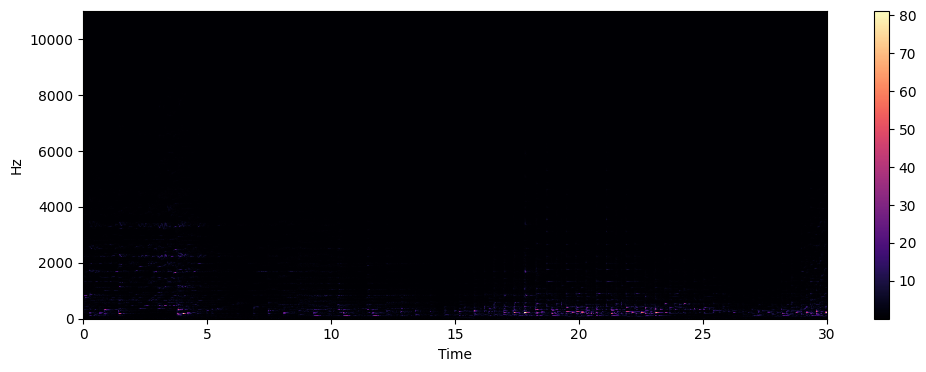

In [ ]:
#Spectrogram
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
print(stft)

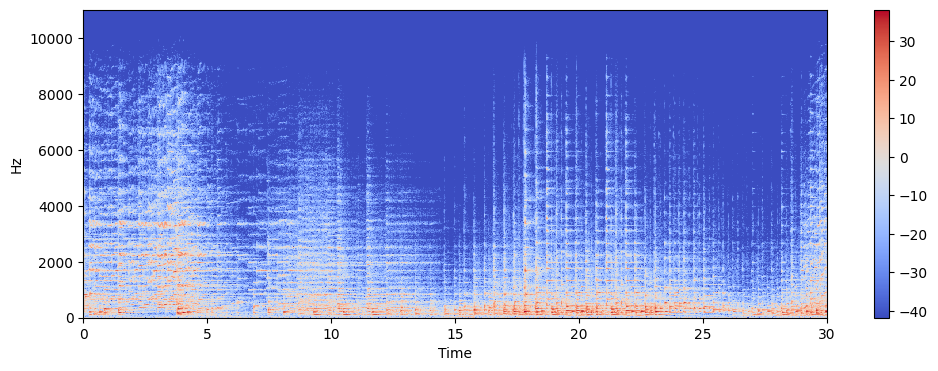

In [ ]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

/var/folders/hd/krkf0bwn52s0tf7r0fqk2c1c0000gp/T/ipykernel_10748/1356212023.py:2: FutureWarning: Pass y=[0.01930786 0.02437378 0.02144409 ... 0.0205896  0.0240686  0.02730347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]


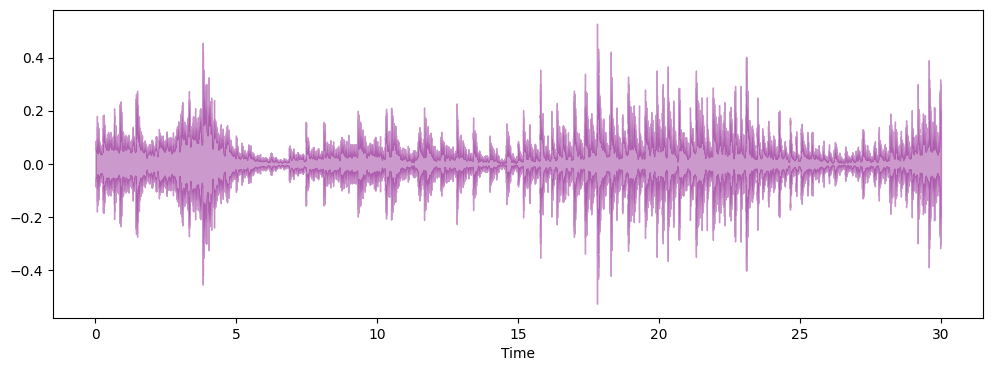

In [ ]:
#computing the rolloff frequency for each frame in a signal
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveshow(data, sr=sr, alpha=0.4, color='Purple')

/var/folders/hd/krkf0bwn52s0tf7r0fqk2c1c0000gp/T/ipykernel_10748/1837279424.py:3: FutureWarning: Pass y=[0.00930786 0.01437378 0.01144409 ... 0.0105896  0.0140686  0.01730347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chroma = librosa.feature.chroma_stft(data, sr=sr)


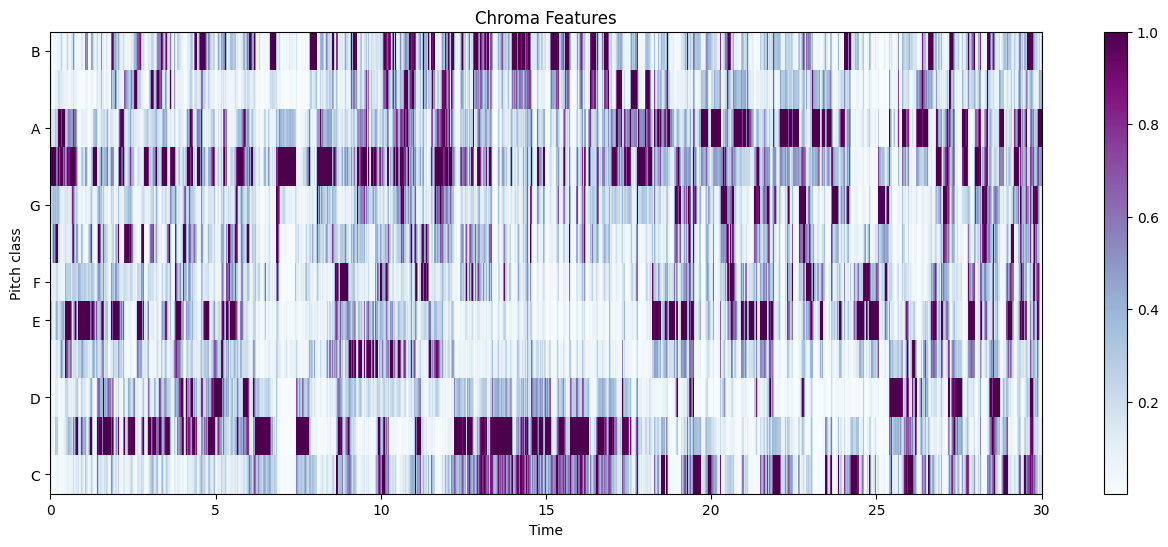

In [ ]:
#Chroma feature or chromagram closely relates to the twelve different pitch classes.
#Chroma features capture harmonic & melodic characteristics of music while being robust to changes.
chroma = librosa.feature.chroma_stft(data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='BuPu')
plt.colorbar()
plt.title("Chroma Features")
plt.show()


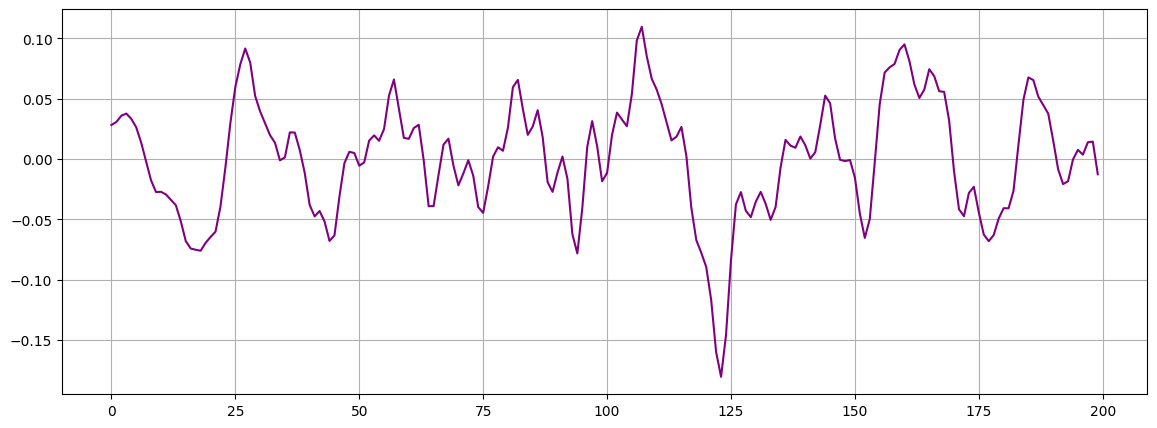

In [ ]:
#The rate at which zero-crossings occur is a simple measure of the frequency content of a signal.
#Zero crossing is said to occur if successive samples have different algebric signs.
start = 1000
end = 1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end], color='Purple')
plt.grid()

In [ ]:
zero_cross_rate = librosa.zero_crossings(data[start:end], pad=False)
print("The number of zero crossings is:",sum(zero_cross_rate))

The number of zero crossings is: 27


In [ ]:
chroma.shape


(12, 1293)

### EXTRACTING AND SCALING THE FEATURES

In [ ]:
#To convert categorical data into model-understandable numerica data
class_list = final_data.iloc[:, -1]
convertor = LabelEncoder()

In [ ]:
#Fitting the label encoder & return encoded labels
y = convertor.fit_transform(class_list)

In [ ]:
y

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
print(final_data.iloc[:, :-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

In [ ]:
#Standard scaler is used to standardize features & look like standard normally distributed data
fit = StandardScaler()
X = fit.fit_transform(np.array(final_data.iloc[:, :-1], dtype = float))

In [ ]:
#genre original

In [ ]:
import json
import math
DATASET_PATH = "/content/drive/MyDrive/cs534_music_classification/Data/genres_original"
JSON_PATH = "/content/drive/MyDrive/cs534_music_classification/data.json"
JSON_EXT_PATH = "/content/drive/MyDrive/cs534_music_classification/data_extended.json"
SAMPLE_RATE = 22050
SAMPLES_TRACK = SAMPLE_RATE * 30 # dataset has 30s tracks

In [ ]:
def save_mfcc(data_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # Store data
    data = {"mapping": [],
           "mfcc": [],
           "labels": []}
    
    num_samples_segment = int(SAMPLES_TRACK / num_segments)
    
    # Loop genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):
        dirpath_components = dirpath.split("/")
        semantic_label = dirpath_components[-1]
        data["mapping"].append(semantic_label)
        print(f"\nProcessing {semantic_label}")
        
        for f in filenames:
            file_path = os.path.join(dirpath, f)
            if file_path=='./Data/genres_original/.DS_Store':
                continue
            try:
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            except:
                pass
            
            for s in range(num_segments):
                start_sample = num_samples_segment * s
                end_sample = start_sample + num_samples_segment
                mfcc = librosa.feature.mfcc(y=signal[start_sample:end_sample],
                                           sr=SAMPLE_RATE,
                                           n_fft=n_fft,
                                           n_mfcc=n_mfcc,
                                           hop_length=hop_length)
                mfcc = mfcc.T

                # Ensure that num of mfccs is the expected
                if len(mfcc) == math.ceil(num_samples_segment / hop_length):
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i-1)
                    print(f"{file_path}, {s}")
        
        with open(json_path, "w") as fp:
            json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_EXT_PATH, n_mfcc=32)


Processing genres_original

Processing pop
./Data/genres_original/pop/pop.00027.wav, 0
./Data/genres_original/pop/pop.00027.wav, 1
./Data/genres_original/pop/pop.00027.wav, 2
./Data/genres_original/pop/pop.00027.wav, 3
./Data/genres_original/pop/pop.00027.wav, 4
./Data/genres_original/pop/pop.00033.wav, 0
./Data/genres_original/pop/pop.00033.wav, 1
./Data/genres_original/pop/pop.00033.wav, 2
./Data/genres_original/pop/pop.00033.wav, 3
./Data/genres_original/pop/pop.00033.wav, 4
./Data/genres_original/pop/pop.00032.wav, 0
./Data/genres_original/pop/pop.00032.wav, 1
./Data/genres_original/pop/pop.00032.wav, 2
./Data/genres_original/pop/pop.00032.wav, 3
./Data/genres_original/pop/pop.00032.wav, 4
./Data/genres_original/pop/pop.00026.wav, 0
./Data/genres_original/pop/pop.00026.wav, 1
./Data/genres_original/pop/pop.00026.wav, 2
./Data/genres_original/pop/pop.00026.wav, 3
./Data/genres_original/pop/pop.00026.wav, 4
./Data/genres_original/pop/pop.00030.wav, 0
./Data/genres_original/pop/pop.0

./Data/genres_original/pop/pop.00042.wav, 1
./Data/genres_original/pop/pop.00042.wav, 2
./Data/genres_original/pop/pop.00042.wav, 3
./Data/genres_original/pop/pop.00042.wav, 4
./Data/genres_original/pop/pop.00095.wav, 0
./Data/genres_original/pop/pop.00095.wav, 1
./Data/genres_original/pop/pop.00095.wav, 2
./Data/genres_original/pop/pop.00095.wav, 3
./Data/genres_original/pop/pop.00095.wav, 4
./Data/genres_original/pop/pop.00081.wav, 0
./Data/genres_original/pop/pop.00081.wav, 1
./Data/genres_original/pop/pop.00081.wav, 2
./Data/genres_original/pop/pop.00081.wav, 3
./Data/genres_original/pop/pop.00081.wav, 4
./Data/genres_original/pop/pop.00080.wav, 0
./Data/genres_original/pop/pop.00080.wav, 1
./Data/genres_original/pop/pop.00080.wav, 2
./Data/genres_original/pop/pop.00080.wav, 3
./Data/genres_original/pop/pop.00080.wav, 4
./Data/genres_original/pop/pop.00094.wav, 0
./Data/genres_original/pop/pop.00094.wav, 1
./Data/genres_original/pop/pop.00094.wav, 2
./Data/genres_original/pop/pop.0

./Data/genres_original/pop/pop.00075.wav, 3
./Data/genres_original/pop/pop.00075.wav, 4
./Data/genres_original/pop/pop.00061.wav, 0
./Data/genres_original/pop/pop.00061.wav, 1
./Data/genres_original/pop/pop.00061.wav, 2
./Data/genres_original/pop/pop.00061.wav, 3
./Data/genres_original/pop/pop.00061.wav, 4
./Data/genres_original/pop/pop.00049.wav, 0
./Data/genres_original/pop/pop.00049.wav, 1
./Data/genres_original/pop/pop.00049.wav, 2
./Data/genres_original/pop/pop.00049.wav, 3
./Data/genres_original/pop/pop.00049.wav, 4
./Data/genres_original/pop/pop.00006.wav, 0
./Data/genres_original/pop/pop.00006.wav, 1
./Data/genres_original/pop/pop.00006.wav, 2
./Data/genres_original/pop/pop.00006.wav, 3
./Data/genres_original/pop/pop.00006.wav, 4
./Data/genres_original/pop/pop.00012.wav, 0
./Data/genres_original/pop/pop.00012.wav, 1
./Data/genres_original/pop/pop.00012.wav, 2
./Data/genres_original/pop/pop.00012.wav, 3
./Data/genres_original/pop/pop.00012.wav, 4
./Data/genres_original/pop/pop.0

./Data/genres_original/metal/metal.00027.wav, 0
./Data/genres_original/metal/metal.00027.wav, 1
./Data/genres_original/metal/metal.00027.wav, 2
./Data/genres_original/metal/metal.00027.wav, 3
./Data/genres_original/metal/metal.00027.wav, 4
./Data/genres_original/metal/metal.00033.wav, 0
./Data/genres_original/metal/metal.00033.wav, 1
./Data/genres_original/metal/metal.00033.wav, 2
./Data/genres_original/metal/metal.00033.wav, 3
./Data/genres_original/metal/metal.00033.wav, 4
./Data/genres_original/metal/metal.00032.wav, 0
./Data/genres_original/metal/metal.00032.wav, 1
./Data/genres_original/metal/metal.00032.wav, 2
./Data/genres_original/metal/metal.00032.wav, 3
./Data/genres_original/metal/metal.00032.wav, 4
./Data/genres_original/metal/metal.00026.wav, 0
./Data/genres_original/metal/metal.00026.wav, 1
./Data/genres_original/metal/metal.00026.wav, 2
./Data/genres_original/metal/metal.00026.wav, 3
./Data/genres_original/metal/metal.00026.wav, 4
./Data/genres_original/metal/metal.00082

./Data/genres_original/metal/metal.00079.wav, 1
./Data/genres_original/metal/metal.00079.wav, 2
./Data/genres_original/metal/metal.00079.wav, 3
./Data/genres_original/metal/metal.00079.wav, 4
./Data/genres_original/metal/metal.00051.wav, 0
./Data/genres_original/metal/metal.00051.wav, 1
./Data/genres_original/metal/metal.00051.wav, 2
./Data/genres_original/metal/metal.00051.wav, 3
./Data/genres_original/metal/metal.00051.wav, 4
./Data/genres_original/metal/metal.00045.wav, 0
./Data/genres_original/metal/metal.00045.wav, 1
./Data/genres_original/metal/metal.00045.wav, 2
./Data/genres_original/metal/metal.00045.wav, 3
./Data/genres_original/metal/metal.00045.wav, 4
./Data/genres_original/metal/metal.00092.wav, 0
./Data/genres_original/metal/metal.00092.wav, 1
./Data/genres_original/metal/metal.00092.wav, 2
./Data/genres_original/metal/metal.00092.wav, 3
./Data/genres_original/metal/metal.00092.wav, 4
./Data/genres_original/metal/metal.00086.wav, 0
./Data/genres_original/metal/metal.00086

./Data/genres_original/metal/metal.00000.wav, 0
./Data/genres_original/metal/metal.00000.wav, 1
./Data/genres_original/metal/metal.00000.wav, 2
./Data/genres_original/metal/metal.00000.wav, 3
./Data/genres_original/metal/metal.00000.wav, 4
./Data/genres_original/metal/metal.00001.wav, 0
./Data/genres_original/metal/metal.00001.wav, 1
./Data/genres_original/metal/metal.00001.wav, 2
./Data/genres_original/metal/metal.00001.wav, 3
./Data/genres_original/metal/metal.00001.wav, 4
./Data/genres_original/metal/metal.00015.wav, 0
./Data/genres_original/metal/metal.00015.wav, 1
./Data/genres_original/metal/metal.00015.wav, 2
./Data/genres_original/metal/metal.00015.wav, 3
./Data/genres_original/metal/metal.00015.wav, 4
./Data/genres_original/metal/metal.00029.wav, 0
./Data/genres_original/metal/metal.00029.wav, 1
./Data/genres_original/metal/metal.00029.wav, 2
./Data/genres_original/metal/metal.00029.wav, 3
./Data/genres_original/metal/metal.00029.wav, 4
./Data/genres_original/metal/metal.00011

./Data/genres_original/disco/disco.00097.wav, 1
./Data/genres_original/disco/disco.00097.wav, 2
./Data/genres_original/disco/disco.00097.wav, 3
./Data/genres_original/disco/disco.00097.wav, 4
./Data/genres_original/disco/disco.00096.wav, 0
./Data/genres_original/disco/disco.00096.wav, 1
./Data/genres_original/disco/disco.00096.wav, 2
./Data/genres_original/disco/disco.00096.wav, 3
./Data/genres_original/disco/disco.00096.wav, 4
./Data/genres_original/disco/disco.00082.wav, 0
./Data/genres_original/disco/disco.00082.wav, 1
./Data/genres_original/disco/disco.00082.wav, 2
./Data/genres_original/disco/disco.00082.wav, 3
./Data/genres_original/disco/disco.00082.wav, 4
./Data/genres_original/disco/disco.00055.wav, 0
./Data/genres_original/disco/disco.00055.wav, 1
./Data/genres_original/disco/disco.00055.wav, 2
./Data/genres_original/disco/disco.00055.wav, 3
./Data/genres_original/disco/disco.00055.wav, 4
./Data/genres_original/disco/disco.00041.wav, 0
./Data/genres_original/disco/disco.00041

./Data/genres_original/disco/disco.00010.wav, 4
./Data/genres_original/disco/disco.00004.wav, 0
./Data/genres_original/disco/disco.00004.wav, 1
./Data/genres_original/disco/disco.00004.wav, 2
./Data/genres_original/disco/disco.00004.wav, 3
./Data/genres_original/disco/disco.00004.wav, 4
./Data/genres_original/disco/disco.00038.wav, 0
./Data/genres_original/disco/disco.00038.wav, 1
./Data/genres_original/disco/disco.00038.wav, 2
./Data/genres_original/disco/disco.00038.wav, 3
./Data/genres_original/disco/disco.00038.wav, 4
./Data/genres_original/disco/disco.00039.wav, 0
./Data/genres_original/disco/disco.00039.wav, 1
./Data/genres_original/disco/disco.00039.wav, 2
./Data/genres_original/disco/disco.00039.wav, 3
./Data/genres_original/disco/disco.00039.wav, 4
./Data/genres_original/disco/disco.00005.wav, 0
./Data/genres_original/disco/disco.00005.wav, 1
./Data/genres_original/disco/disco.00005.wav, 2
./Data/genres_original/disco/disco.00005.wav, 3
./Data/genres_original/disco/disco.00005

./Data/genres_original/disco/disco.00074.wav, 2
./Data/genres_original/disco/disco.00074.wav, 3
./Data/genres_original/disco/disco.00074.wav, 4
./Data/genres_original/disco/disco.00060.wav, 0
./Data/genres_original/disco/disco.00060.wav, 1
./Data/genres_original/disco/disco.00060.wav, 2
./Data/genres_original/disco/disco.00060.wav, 3
./Data/genres_original/disco/disco.00060.wav, 4
./Data/genres_original/disco/disco.00048.wav, 0
./Data/genres_original/disco/disco.00048.wav, 1
./Data/genres_original/disco/disco.00048.wav, 2
./Data/genres_original/disco/disco.00048.wav, 3
./Data/genres_original/disco/disco.00048.wav, 4
./Data/genres_original/disco/disco.00076.wav, 0
./Data/genres_original/disco/disco.00076.wav, 1
./Data/genres_original/disco/disco.00076.wav, 2
./Data/genres_original/disco/disco.00076.wav, 3
./Data/genres_original/disco/disco.00076.wav, 4
./Data/genres_original/disco/disco.00062.wav, 0
./Data/genres_original/disco/disco.00062.wav, 1
./Data/genres_original/disco/disco.00062

./Data/genres_original/blues/blues.00082.wav, 2
./Data/genres_original/blues/blues.00082.wav, 3
./Data/genres_original/blues/blues.00082.wav, 4
./Data/genres_original/blues/blues.00069.wav, 0
./Data/genres_original/blues/blues.00069.wav, 1
./Data/genres_original/blues/blues.00069.wav, 2
./Data/genres_original/blues/blues.00069.wav, 3
./Data/genres_original/blues/blues.00069.wav, 4
./Data/genres_original/blues/blues.00055.wav, 0
./Data/genres_original/blues/blues.00055.wav, 1
./Data/genres_original/blues/blues.00055.wav, 2
./Data/genres_original/blues/blues.00055.wav, 3
./Data/genres_original/blues/blues.00055.wav, 4
./Data/genres_original/blues/blues.00041.wav, 0
./Data/genres_original/blues/blues.00041.wav, 1
./Data/genres_original/blues/blues.00041.wav, 2
./Data/genres_original/blues/blues.00041.wav, 3
./Data/genres_original/blues/blues.00041.wav, 4
./Data/genres_original/blues/blues.00040.wav, 0
./Data/genres_original/blues/blues.00040.wav, 1
./Data/genres_original/blues/blues.00040

./Data/genres_original/blues/blues.00010.wav, 1
./Data/genres_original/blues/blues.00010.wav, 2
./Data/genres_original/blues/blues.00010.wav, 3
./Data/genres_original/blues/blues.00010.wav, 4
./Data/genres_original/blues/blues.00004.wav, 0
./Data/genres_original/blues/blues.00004.wav, 1
./Data/genres_original/blues/blues.00004.wav, 2
./Data/genres_original/blues/blues.00004.wav, 3
./Data/genres_original/blues/blues.00004.wav, 4
./Data/genres_original/blues/blues.00028.wav, 0
./Data/genres_original/blues/blues.00028.wav, 1
./Data/genres_original/blues/blues.00028.wav, 2
./Data/genres_original/blues/blues.00028.wav, 3
./Data/genres_original/blues/blues.00028.wav, 4
./Data/genres_original/blues/blues.00000.wav, 0
./Data/genres_original/blues/blues.00000.wav, 1
./Data/genres_original/blues/blues.00000.wav, 2
./Data/genres_original/blues/blues.00000.wav, 3
./Data/genres_original/blues/blues.00000.wav, 4
./Data/genres_original/blues/blues.00014.wav, 0
./Data/genres_original/blues/blues.00014


Processing reggae
./Data/genres_original/reggae/reggae.00080.wav, 0
./Data/genres_original/reggae/reggae.00080.wav, 1
./Data/genres_original/reggae/reggae.00080.wav, 2
./Data/genres_original/reggae/reggae.00080.wav, 3
./Data/genres_original/reggae/reggae.00080.wav, 4
./Data/genres_original/reggae/reggae.00094.wav, 0
./Data/genres_original/reggae/reggae.00094.wav, 1
./Data/genres_original/reggae/reggae.00094.wav, 2
./Data/genres_original/reggae/reggae.00094.wav, 3
./Data/genres_original/reggae/reggae.00094.wav, 4
./Data/genres_original/reggae/reggae.00043.wav, 0
./Data/genres_original/reggae/reggae.00043.wav, 1
./Data/genres_original/reggae/reggae.00043.wav, 2
./Data/genres_original/reggae/reggae.00043.wav, 3
./Data/genres_original/reggae/reggae.00043.wav, 4
./Data/genres_original/reggae/reggae.00057.wav, 0
./Data/genres_original/reggae/reggae.00057.wav, 1
./Data/genres_original/reggae/reggae.00057.wav, 2
./Data/genres_original/reggae/reggae.00057.wav, 3
./Data/genres_original/reggae/r

./Data/genres_original/reggae/reggae.00047.wav, 0
./Data/genres_original/reggae/reggae.00047.wav, 1
./Data/genres_original/reggae/reggae.00047.wav, 2
./Data/genres_original/reggae/reggae.00047.wav, 3
./Data/genres_original/reggae/reggae.00047.wav, 4
./Data/genres_original/reggae/reggae.00090.wav, 0
./Data/genres_original/reggae/reggae.00090.wav, 1
./Data/genres_original/reggae/reggae.00090.wav, 2
./Data/genres_original/reggae/reggae.00090.wav, 3
./Data/genres_original/reggae/reggae.00090.wav, 4
./Data/genres_original/reggae/reggae.00084.wav, 0
./Data/genres_original/reggae/reggae.00084.wav, 1
./Data/genres_original/reggae/reggae.00084.wav, 2
./Data/genres_original/reggae/reggae.00084.wav, 3
./Data/genres_original/reggae/reggae.00084.wav, 4
./Data/genres_original/reggae/reggae.00020.wav, 0
./Data/genres_original/reggae/reggae.00020.wav, 1
./Data/genres_original/reggae/reggae.00020.wav, 2
./Data/genres_original/reggae/reggae.00020.wav, 3
./Data/genres_original/reggae/reggae.00020.wav, 4


./Data/genres_original/reggae/reggae.00013.wav, 4
./Data/genres_original/reggae/reggae.00007.wav, 0
./Data/genres_original/reggae/reggae.00007.wav, 1
./Data/genres_original/reggae/reggae.00007.wav, 2
./Data/genres_original/reggae/reggae.00007.wav, 3
./Data/genres_original/reggae/reggae.00007.wav, 4
./Data/genres_original/reggae/reggae.00006.wav, 0
./Data/genres_original/reggae/reggae.00006.wav, 1
./Data/genres_original/reggae/reggae.00006.wav, 2
./Data/genres_original/reggae/reggae.00006.wav, 3
./Data/genres_original/reggae/reggae.00006.wav, 4
./Data/genres_original/reggae/reggae.00012.wav, 0
./Data/genres_original/reggae/reggae.00012.wav, 1
./Data/genres_original/reggae/reggae.00012.wav, 2
./Data/genres_original/reggae/reggae.00012.wav, 3
./Data/genres_original/reggae/reggae.00012.wav, 4
./Data/genres_original/reggae/reggae.00038.wav, 0
./Data/genres_original/reggae/reggae.00038.wav, 1
./Data/genres_original/reggae/reggae.00038.wav, 2
./Data/genres_original/reggae/reggae.00038.wav, 3



Processing classical
./Data/genres_original/classical/classical.00079.wav, 0
./Data/genres_original/classical/classical.00079.wav, 1
./Data/genres_original/classical/classical.00079.wav, 2
./Data/genres_original/classical/classical.00079.wav, 3
./Data/genres_original/classical/classical.00079.wav, 4
./Data/genres_original/classical/classical.00045.wav, 0
./Data/genres_original/classical/classical.00045.wav, 1
./Data/genres_original/classical/classical.00045.wav, 2
./Data/genres_original/classical/classical.00045.wav, 3
./Data/genres_original/classical/classical.00045.wav, 4
./Data/genres_original/classical/classical.00051.wav, 0
./Data/genres_original/classical/classical.00051.wav, 1
./Data/genres_original/classical/classical.00051.wav, 2
./Data/genres_original/classical/classical.00051.wav, 3
./Data/genres_original/classical/classical.00051.wav, 4
./Data/genres_original/classical/classical.00086.wav, 0
./Data/genres_original/classical/classical.00086.wav, 1
./Data/genres_original/cla

./Data/genres_original/classical/classical.00097.wav, 4
./Data/genres_original/classical/classical.00096.wav, 0
./Data/genres_original/classical/classical.00096.wav, 1
./Data/genres_original/classical/classical.00096.wav, 2
./Data/genres_original/classical/classical.00096.wav, 3
./Data/genres_original/classical/classical.00096.wav, 4
./Data/genres_original/classical/classical.00082.wav, 0
./Data/genres_original/classical/classical.00082.wav, 1
./Data/genres_original/classical/classical.00082.wav, 2
./Data/genres_original/classical/classical.00082.wav, 3
./Data/genres_original/classical/classical.00082.wav, 4
./Data/genres_original/classical/classical.00069.wav, 0
./Data/genres_original/classical/classical.00069.wav, 1
./Data/genres_original/classical/classical.00069.wav, 2
./Data/genres_original/classical/classical.00069.wav, 3
./Data/genres_original/classical/classical.00069.wav, 4
./Data/genres_original/classical/classical.00055.wav, 0
./Data/genres_original/classical/classical.00055

./Data/genres_original/classical/classical.00004.wav, 0
./Data/genres_original/classical/classical.00004.wav, 1
./Data/genres_original/classical/classical.00004.wav, 2
./Data/genres_original/classical/classical.00004.wav, 3
./Data/genres_original/classical/classical.00004.wav, 4
./Data/genres_original/classical/classical.00005.wav, 0
./Data/genres_original/classical/classical.00005.wav, 1
./Data/genres_original/classical/classical.00005.wav, 2
./Data/genres_original/classical/classical.00005.wav, 3
./Data/genres_original/classical/classical.00005.wav, 4
./Data/genres_original/classical/classical.00011.wav, 0
./Data/genres_original/classical/classical.00011.wav, 1
./Data/genres_original/classical/classical.00011.wav, 2
./Data/genres_original/classical/classical.00011.wav, 3
./Data/genres_original/classical/classical.00011.wav, 4
./Data/genres_original/classical/classical.00039.wav, 0
./Data/genres_original/classical/classical.00039.wav, 1
./Data/genres_original/classical/classical.00039

./Data/genres_original/classical/classical.00077.wav, 0
./Data/genres_original/classical/classical.00077.wav, 1
./Data/genres_original/classical/classical.00077.wav, 2
./Data/genres_original/classical/classical.00077.wav, 3
./Data/genres_original/classical/classical.00077.wav, 4
./Data/genres_original/classical/classical.00061.wav, 0
./Data/genres_original/classical/classical.00061.wav, 1
./Data/genres_original/classical/classical.00061.wav, 2
./Data/genres_original/classical/classical.00061.wav, 3
./Data/genres_original/classical/classical.00061.wav, 4
./Data/genres_original/classical/classical.00075.wav, 0
./Data/genres_original/classical/classical.00075.wav, 1
./Data/genres_original/classical/classical.00075.wav, 2
./Data/genres_original/classical/classical.00075.wav, 3
./Data/genres_original/classical/classical.00075.wav, 4
./Data/genres_original/classical/classical.00049.wav, 0
./Data/genres_original/classical/classical.00049.wav, 1
./Data/genres_original/classical/classical.00049

./Data/genres_original/rock/rock.00059.wav, 0
./Data/genres_original/rock/rock.00059.wav, 1
./Data/genres_original/rock/rock.00059.wav, 2
./Data/genres_original/rock/rock.00059.wav, 3
./Data/genres_original/rock/rock.00059.wav, 4
./Data/genres_original/rock/rock.00058.wav, 0
./Data/genres_original/rock/rock.00058.wav, 1
./Data/genres_original/rock/rock.00058.wav, 2
./Data/genres_original/rock/rock.00058.wav, 3
./Data/genres_original/rock/rock.00058.wav, 4
./Data/genres_original/rock/rock.00070.wav, 0
./Data/genres_original/rock/rock.00070.wav, 1
./Data/genres_original/rock/rock.00070.wav, 2
./Data/genres_original/rock/rock.00070.wav, 3
./Data/genres_original/rock/rock.00070.wav, 4
./Data/genres_original/rock/rock.00064.wav, 0
./Data/genres_original/rock/rock.00064.wav, 1
./Data/genres_original/rock/rock.00064.wav, 2
./Data/genres_original/rock/rock.00064.wav, 3
./Data/genres_original/rock/rock.00064.wav, 4
./Data/genres_original/rock/rock.00048.wav, 0
./Data/genres_original/rock/rock.0

./Data/genres_original/rock/rock.00069.wav, 2
./Data/genres_original/rock/rock.00069.wav, 3
./Data/genres_original/rock/rock.00069.wav, 4
./Data/genres_original/rock/rock.00041.wav, 0
./Data/genres_original/rock/rock.00041.wav, 1
./Data/genres_original/rock/rock.00041.wav, 2
./Data/genres_original/rock/rock.00041.wav, 3
./Data/genres_original/rock/rock.00041.wav, 4
./Data/genres_original/rock/rock.00055.wav, 0
./Data/genres_original/rock/rock.00055.wav, 1
./Data/genres_original/rock/rock.00055.wav, 2
./Data/genres_original/rock/rock.00055.wav, 3
./Data/genres_original/rock/rock.00055.wav, 4
./Data/genres_original/rock/rock.00054.wav, 0
./Data/genres_original/rock/rock.00054.wav, 1
./Data/genres_original/rock/rock.00054.wav, 2
./Data/genres_original/rock/rock.00054.wav, 3
./Data/genres_original/rock/rock.00054.wav, 4
./Data/genres_original/rock/rock.00040.wav, 0
./Data/genres_original/rock/rock.00040.wav, 1
./Data/genres_original/rock/rock.00040.wav, 2
./Data/genres_original/rock/rock.0

./Data/genres_original/hiphop/hiphop.00035.wav, 0
./Data/genres_original/hiphop/hiphop.00035.wav, 1
./Data/genres_original/hiphop/hiphop.00035.wav, 2
./Data/genres_original/hiphop/hiphop.00035.wav, 3
./Data/genres_original/hiphop/hiphop.00035.wav, 4
./Data/genres_original/hiphop/hiphop.00021.wav, 0
./Data/genres_original/hiphop/hiphop.00021.wav, 1
./Data/genres_original/hiphop/hiphop.00021.wav, 2
./Data/genres_original/hiphop/hiphop.00021.wav, 3
./Data/genres_original/hiphop/hiphop.00021.wav, 4
./Data/genres_original/hiphop/hiphop.00020.wav, 0
./Data/genres_original/hiphop/hiphop.00020.wav, 1
./Data/genres_original/hiphop/hiphop.00020.wav, 2
./Data/genres_original/hiphop/hiphop.00020.wav, 3
./Data/genres_original/hiphop/hiphop.00020.wav, 4
./Data/genres_original/hiphop/hiphop.00034.wav, 0
./Data/genres_original/hiphop/hiphop.00034.wav, 1
./Data/genres_original/hiphop/hiphop.00034.wav, 2
./Data/genres_original/hiphop/hiphop.00034.wav, 3
./Data/genres_original/hiphop/hiphop.00034.wav, 4


./Data/genres_original/hiphop/hiphop.00047.wav, 0
./Data/genres_original/hiphop/hiphop.00047.wav, 1
./Data/genres_original/hiphop/hiphop.00047.wav, 2
./Data/genres_original/hiphop/hiphop.00047.wav, 3
./Data/genres_original/hiphop/hiphop.00047.wav, 4
./Data/genres_original/hiphop/hiphop.00090.wav, 0
./Data/genres_original/hiphop/hiphop.00090.wav, 1
./Data/genres_original/hiphop/hiphop.00090.wav, 2
./Data/genres_original/hiphop/hiphop.00090.wav, 3
./Data/genres_original/hiphop/hiphop.00090.wav, 4
./Data/genres_original/hiphop/hiphop.00084.wav, 0
./Data/genres_original/hiphop/hiphop.00084.wav, 1
./Data/genres_original/hiphop/hiphop.00084.wav, 2
./Data/genres_original/hiphop/hiphop.00084.wav, 3
./Data/genres_original/hiphop/hiphop.00084.wav, 4
./Data/genres_original/hiphop/hiphop.00085.wav, 0
./Data/genres_original/hiphop/hiphop.00085.wav, 1
./Data/genres_original/hiphop/hiphop.00085.wav, 2
./Data/genres_original/hiphop/hiphop.00085.wav, 3
./Data/genres_original/hiphop/hiphop.00085.wav, 4


./Data/genres_original/hiphop/hiphop.00067.wav, 0
./Data/genres_original/hiphop/hiphop.00067.wav, 1
./Data/genres_original/hiphop/hiphop.00067.wav, 2
./Data/genres_original/hiphop/hiphop.00067.wav, 3
./Data/genres_original/hiphop/hiphop.00067.wav, 4
./Data/genres_original/hiphop/hiphop.00073.wav, 0
./Data/genres_original/hiphop/hiphop.00073.wav, 1
./Data/genres_original/hiphop/hiphop.00073.wav, 2
./Data/genres_original/hiphop/hiphop.00073.wav, 3
./Data/genres_original/hiphop/hiphop.00073.wav, 4
./Data/genres_original/hiphop/hiphop.00065.wav, 0
./Data/genres_original/hiphop/hiphop.00065.wav, 1
./Data/genres_original/hiphop/hiphop.00065.wav, 2
./Data/genres_original/hiphop/hiphop.00065.wav, 3
./Data/genres_original/hiphop/hiphop.00065.wav, 4
./Data/genres_original/hiphop/hiphop.00071.wav, 0
./Data/genres_original/hiphop/hiphop.00071.wav, 1
./Data/genres_original/hiphop/hiphop.00071.wav, 2
./Data/genres_original/hiphop/hiphop.00071.wav, 3
./Data/genres_original/hiphop/hiphop.00071.wav, 4


./Data/genres_original/country/country.00089.wav, 0
./Data/genres_original/country/country.00089.wav, 1
./Data/genres_original/country/country.00089.wav, 2
./Data/genres_original/country/country.00089.wav, 3
./Data/genres_original/country/country.00089.wav, 4
./Data/genres_original/country/country.00048.wav, 0
./Data/genres_original/country/country.00048.wav, 1
./Data/genres_original/country/country.00048.wav, 2
./Data/genres_original/country/country.00048.wav, 3
./Data/genres_original/country/country.00048.wav, 4
./Data/genres_original/country/country.00074.wav, 0
./Data/genres_original/country/country.00074.wav, 1
./Data/genres_original/country/country.00074.wav, 2
./Data/genres_original/country/country.00074.wav, 3
./Data/genres_original/country/country.00074.wav, 4
./Data/genres_original/country/country.00060.wav, 0
./Data/genres_original/country/country.00060.wav, 1
./Data/genres_original/country/country.00060.wav, 2
./Data/genres_original/country/country.00060.wav, 3
./Data/genre

./Data/genres_original/country/country.00005.wav, 0
./Data/genres_original/country/country.00005.wav, 1
./Data/genres_original/country/country.00005.wav, 2
./Data/genres_original/country/country.00005.wav, 3
./Data/genres_original/country/country.00005.wav, 4
./Data/genres_original/country/country.00011.wav, 0
./Data/genres_original/country/country.00011.wav, 1
./Data/genres_original/country/country.00011.wav, 2
./Data/genres_original/country/country.00011.wav, 3
./Data/genres_original/country/country.00011.wav, 4
./Data/genres_original/country/country.00039.wav, 0
./Data/genres_original/country/country.00039.wav, 1
./Data/genres_original/country/country.00039.wav, 2
./Data/genres_original/country/country.00039.wav, 3
./Data/genres_original/country/country.00039.wav, 4
./Data/genres_original/country/country.00038.wav, 0
./Data/genres_original/country/country.00038.wav, 1
./Data/genres_original/country/country.00038.wav, 2
./Data/genres_original/country/country.00038.wav, 3
./Data/genre

./Data/genres_original/country/country.00080.wav, 3
./Data/genres_original/country/country.00080.wav, 4
./Data/genres_original/country/country.00096.wav, 0
./Data/genres_original/country/country.00096.wav, 1
./Data/genres_original/country/country.00096.wav, 2
./Data/genres_original/country/country.00096.wav, 3
./Data/genres_original/country/country.00096.wav, 4
./Data/genres_original/country/country.00082.wav, 0
./Data/genres_original/country/country.00082.wav, 1
./Data/genres_original/country/country.00082.wav, 2
./Data/genres_original/country/country.00082.wav, 3
./Data/genres_original/country/country.00082.wav, 4
./Data/genres_original/country/country.00069.wav, 0
./Data/genres_original/country/country.00069.wav, 1
./Data/genres_original/country/country.00069.wav, 2
./Data/genres_original/country/country.00069.wav, 3
./Data/genres_original/country/country.00069.wav, 4
./Data/genres_original/country/country.00055.wav, 0
./Data/genres_original/country/country.00055.wav, 1
./Data/genre

./Data/genres_original/jazz/jazz.00015.wav, 0
./Data/genres_original/jazz/jazz.00015.wav, 1
./Data/genres_original/jazz/jazz.00015.wav, 2
./Data/genres_original/jazz/jazz.00015.wav, 3
./Data/genres_original/jazz/jazz.00015.wav, 4
./Data/genres_original/jazz/jazz.00029.wav, 0
./Data/genres_original/jazz/jazz.00029.wav, 1
./Data/genres_original/jazz/jazz.00029.wav, 2
./Data/genres_original/jazz/jazz.00029.wav, 3
./Data/genres_original/jazz/jazz.00029.wav, 4
./Data/genres_original/jazz/jazz.00028.wav, 0
./Data/genres_original/jazz/jazz.00028.wav, 1
./Data/genres_original/jazz/jazz.00028.wav, 2
./Data/genres_original/jazz/jazz.00028.wav, 3
./Data/genres_original/jazz/jazz.00028.wav, 4
./Data/genres_original/jazz/jazz.00014.wav, 0
./Data/genres_original/jazz/jazz.00014.wav, 1
./Data/genres_original/jazz/jazz.00014.wav, 2
./Data/genres_original/jazz/jazz.00014.wav, 3
./Data/genres_original/jazz/jazz.00014.wav, 4
./Data/genres_original/jazz/jazz.00000.wav, 0
./Data/genres_original/jazz/jazz.0

./Data/genres_original/jazz/jazz.00059.wav, 4
./Data/genres_original/jazz/jazz.00054.wav, 0
./Data/genres_original/jazz/jazz.00054.wav, 1
./Data/genres_original/jazz/jazz.00054.wav, 2
./Data/genres_original/jazz/jazz.00054.wav, 3
./Data/genres_original/jazz/jazz.00054.wav, 4
./Data/genres_original/jazz/jazz.00040.wav, 0
./Data/genres_original/jazz/jazz.00040.wav, 1
./Data/genres_original/jazz/jazz.00040.wav, 2
./Data/genres_original/jazz/jazz.00040.wav, 3
./Data/genres_original/jazz/jazz.00040.wav, 4
./Data/genres_original/jazz/jazz.00068.wav, 0
./Data/genres_original/jazz/jazz.00068.wav, 1
./Data/genres_original/jazz/jazz.00068.wav, 2
./Data/genres_original/jazz/jazz.00068.wav, 3
./Data/genres_original/jazz/jazz.00068.wav, 4
./Data/genres_original/jazz/jazz.00097.wav, 0
./Data/genres_original/jazz/jazz.00097.wav, 1
./Data/genres_original/jazz/jazz.00097.wav, 2
./Data/genres_original/jazz/jazz.00097.wav, 3
./Data/genres_original/jazz/jazz.00097.wav, 4
./Data/genres_original/jazz/jazz.0

./Data/genres_original/jazz/jazz.00020.wav, 2
./Data/genres_original/jazz/jazz.00020.wav, 3
./Data/genres_original/jazz/jazz.00020.wav, 4
./Data/genres_original/jazz/jazz.00034.wav, 0
./Data/genres_original/jazz/jazz.00034.wav, 1
./Data/genres_original/jazz/jazz.00034.wav, 2
./Data/genres_original/jazz/jazz.00034.wav, 3
./Data/genres_original/jazz/jazz.00034.wav, 4
./Data/genres_original/jazz/jazz.00008.wav, 0
./Data/genres_original/jazz/jazz.00008.wav, 1
./Data/genres_original/jazz/jazz.00008.wav, 2
./Data/genres_original/jazz/jazz.00008.wav, 3
./Data/genres_original/jazz/jazz.00008.wav, 4
./Data/genres_original/jazz/jazz.00009.wav, 0
./Data/genres_original/jazz/jazz.00009.wav, 1
./Data/genres_original/jazz/jazz.00009.wav, 2
./Data/genres_original/jazz/jazz.00009.wav, 3
./Data/genres_original/jazz/jazz.00009.wav, 4
./Data/genres_original/jazz/jazz.00035.wav, 0
./Data/genres_original/jazz/jazz.00035.wav, 1
./Data/genres_original/jazz/jazz.00035.wav, 2
./Data/genres_original/jazz/jazz.0

In [ ]:
def load_dataset(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

def split_in_sets_cnn(X, y, train_size, val_split):
    print(f"X total = {X.shape}")
    print(f"y total = {y.shape}")
    X_train, X_ev, y_train, y_ev = train_test_split(X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = train_test_split(X_ev, y_ev, train_size=val_split)
    
    print(f"X train = {X_train.shape}")
    print(f"y train = {y_train.shape}")
    print(f"X val = {X_val.shape}")
    print(f"y val = {y_val.shape}")
    print(f"X test = {X_test.shape}")
    print(f"y test = {y_test.shape}")
    
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X, y = load_dataset(JSON_EXT_PATH)
X_train, X_val, X_test, y_train, y_val, y_test = split_in_sets_cnn(X, y, train_size=0.6, val_split=0.5)

X total = (4998, 259, 32)
y total = (4998,)
X train = (2998, 259, 32)
y train = (2998,)
X val = (1000, 259, 32)
y val = (1000,)
X test = (1000, 259, 32)
y test = (1000,)


**SPLIT THE DATA INTO TRAINING DATA & TEST DATA**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
len(y_train)

6693

In [ ]:
len(y_test)

3297

In [ ]:
#The loss is calculated using sparse_categorical_crossentropy function
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                   metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, 
                     batch_size=batch_size)

In [ ]:
#Plotting the curves
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()
    

<AxesSubplot: >

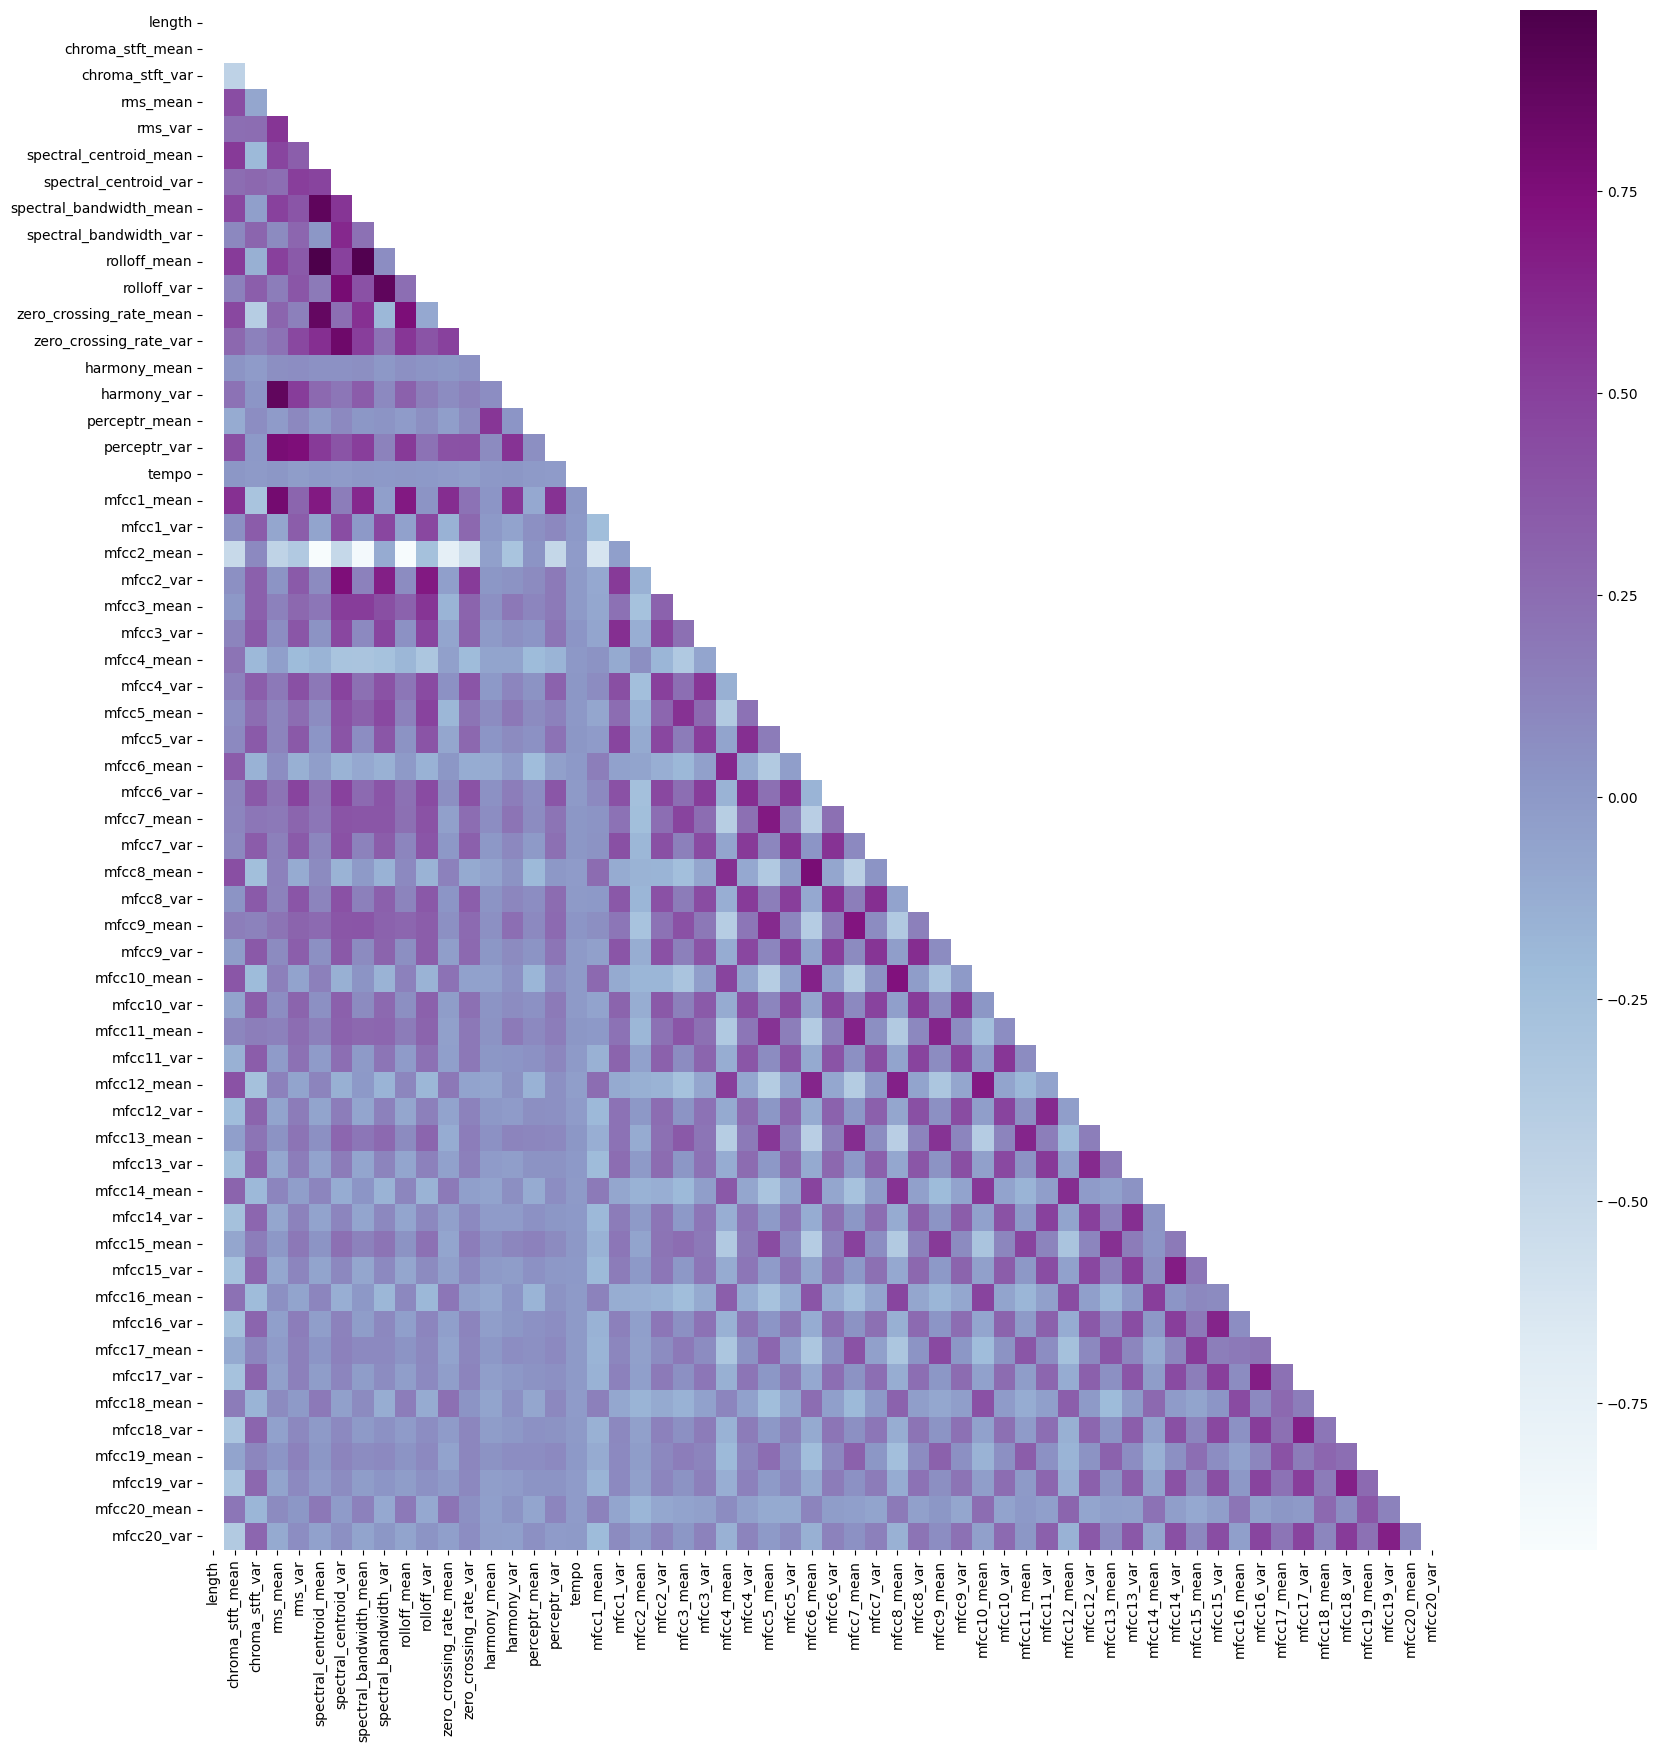

In [ ]:
#correlation
corr = final_data.corr()
#Creation of a mask for the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap="BuPu")

**XGBOOST**

* XGBoost (eXtreme Gradient Boosting) is a popular supervised-learning algorithm used for regression and classification on large datasets. It uses sequentially-built shallow decision trees to provide accurate results and a highly-scalable training method that avoids overfitting.

* XGBClassifier is a scikit-learn API compatible class for classification.

In [ ]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

ValueError: Please reshape the input data into 2-dimensional matrix.

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, labels=target_names)}')

NotFittedError: need to call fit or load_model beforehand

<AxesSubplot: >

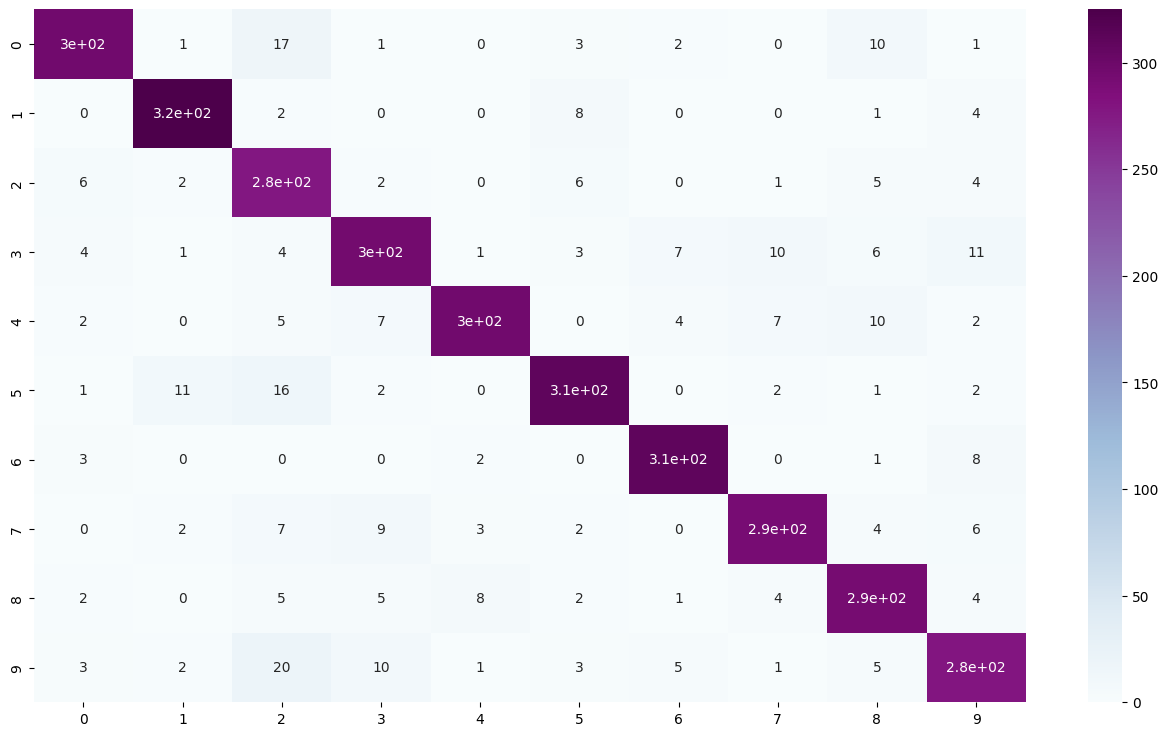

In [ ]:
#Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (16, 9))
sns.heatmap(conf_mat,cmap="BuPu", annot=True, xticklabels = target_names, yticklabels = target_names )

**Convolutional Neural Network (CNN)**




In [ ]:
#Here, we use Adam optimizer to train the model
#All of the hidden layers are using RELU activation function
#Output Layer uses softmax function


model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(10, activation="softmax"),
    
])
print(model.summary())
model_history = trainModel(model=model, epochs=1500, optimizer='adam')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("The test loss is :",test_loss)
print("\nThe test Accuracy is :",test_accuracy*100)

In [ ]:
#Plot the loss & accuracy curves for training & validation
plotValidate(model_history)

In [ ]:
from IPython.display import Image
import os

Image('/kaggle/input/music-pic-2/music_pic_2.jpg')

**CONCLUSION**

**According to Anamika Mishra, "Music gives wings to heart & takes it to the world of joy."**

**According to Martin Luther, "Music is a fair & glorious gift of God."**

**Hence, from this notebook we can conclude that Music Genre Classification is one of the many branches of music information retrieval. Neural Networks are very effective in it & tensorflow is very useful in implementing Convolutional Neural Network (CNN) that helps in the classifying process especially to classify music clips into different genres.**